# This is an example of an MLP doing classification

We will be using here the ['covtype'](https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset) dataset from sklearn, which is a multi-class classification task related to forest cover types (7 classes).

In [33]:
# 1) Imports and general setup

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# For reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [34]:
# 2) Load the data
#    Here we use the 'covtype' dataset from sklearn, which is a multi-class
#    classification task related to forest cover types (7 classes).
#
#    In real-life situations, you often have to handle missing values,
#    categorical data, outliers, etc., before getting to this point.

covtype_data = fetch_covtype(as_frame=True)
X = covtype_data.data  # Features as a pandas DataFrame
y = covtype_data.target  # Target classes (1..7)

# Note: The target classes in 'covtype' are labeled from 1 to 7.
# For PyTorch's CrossEntropyLoss, we typically want labels from 0..6.
y = y - 1  # shift labels to 0..6

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique classes (after shifting): {np.unique(y)}")

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X.values,
    y.values,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

# Scale the features (we assume they're all numeric)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


Feature matrix shape: (581012, 54)
Labels shape: (581012,)
Unique classes (after shifting): [0 1 2 3 4 5 6]


In [35]:
# 3) Create a custom Dataset class
#    This will handle the classification data: features and integer labels.

class CovTypeDataset(Dataset):
    """PyTorch Dataset for multi-class classification using the CovType data."""

    def __init__(self, features, targets=None):
        """
        Args:
            features (np.ndarray): shape (N, num_features)
            targets (np.ndarray, optional): shape (N,) with class indices (0..6).
                                            If None, we assume inference mode.
        """
        self.features = torch.as_tensor(features, dtype=torch.float32)

        # For classification, targets should be integers (class indices)
        if targets is not None:
            self.targets = torch.as_tensor(targets, dtype=torch.long)
        else:
            self.targets = None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.targets is not None:
            return self.features[idx], self.targets[idx]
        return self.features[idx]

    def input_size(self):
        return self.features.shape[1]


In [36]:
# 4) Instantiate Dataset objects and DataLoaders

train_dataset = CovTypeDataset(X_train_scaled, y_train)
val_dataset = CovTypeDataset(X_val_scaled, y_val)


def create_dataloader(dataset, batch_size=256):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # set to 0 for debugging; >=1 if you want faster loading
        pin_memory=False  # set True if using GPU + num_workers>0
    )


train_loader = create_dataloader(train_dataset, batch_size=256)
val_loader = create_dataloader(val_dataset, batch_size=256)


In [37]:
# 5) Define the MLP Model for classification

class CovTypeMLP(nn.Module):
    def __init__(self, input_size, num_classes=7):
        super(CovTypeMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)  # 7-class output
        )

    def forward(self, x):
        return self.layers(x)


In [38]:
# 6) Define training and validation functions

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch (classification)."""
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)  # shape: (batch_size, num_classes)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    """Validate the model for classification."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item()

            # For classification accuracy
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy


In [39]:
# 7) Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CovTypeMLP(input_size=train_dataset.input_size(), num_classes=7).to(device)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
weights = 1.0 / class_counts
class_weights = torch.as_tensor(weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights)  # standard for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

n_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{n_epochs}]"
          f" | Train Loss: {train_loss:.4f}"
          f" | Val Loss: {val_loss:.4f}"
          f" | Val Acc: {val_acc * 100:.2f}%")

Using device: cuda
Epoch [1/10] | Train Loss: 0.7754 | Val Loss: 0.6226 | Val Acc: 64.33%
Epoch [2/10] | Train Loss: 0.6199 | Val Loss: 0.5485 | Val Acc: 63.82%
Epoch [3/10] | Train Loss: 0.5737 | Val Loss: 0.5188 | Val Acc: 67.78%
Epoch [4/10] | Train Loss: 0.5405 | Val Loss: 0.4880 | Val Acc: 68.33%
Epoch [5/10] | Train Loss: 0.5179 | Val Loss: 0.4636 | Val Acc: 70.92%
Epoch [6/10] | Train Loss: 0.5015 | Val Loss: 0.4509 | Val Acc: 69.79%
Epoch [7/10] | Train Loss: 0.4892 | Val Loss: 0.4332 | Val Acc: 70.36%
Epoch [8/10] | Train Loss: 0.4762 | Val Loss: 0.4165 | Val Acc: 71.21%
Epoch [9/10] | Train Loss: 0.4674 | Val Loss: 0.4125 | Val Acc: 72.24%
Epoch [10/10] | Train Loss: 0.4622 | Val Loss: 0.4131 | Val Acc: 71.47%


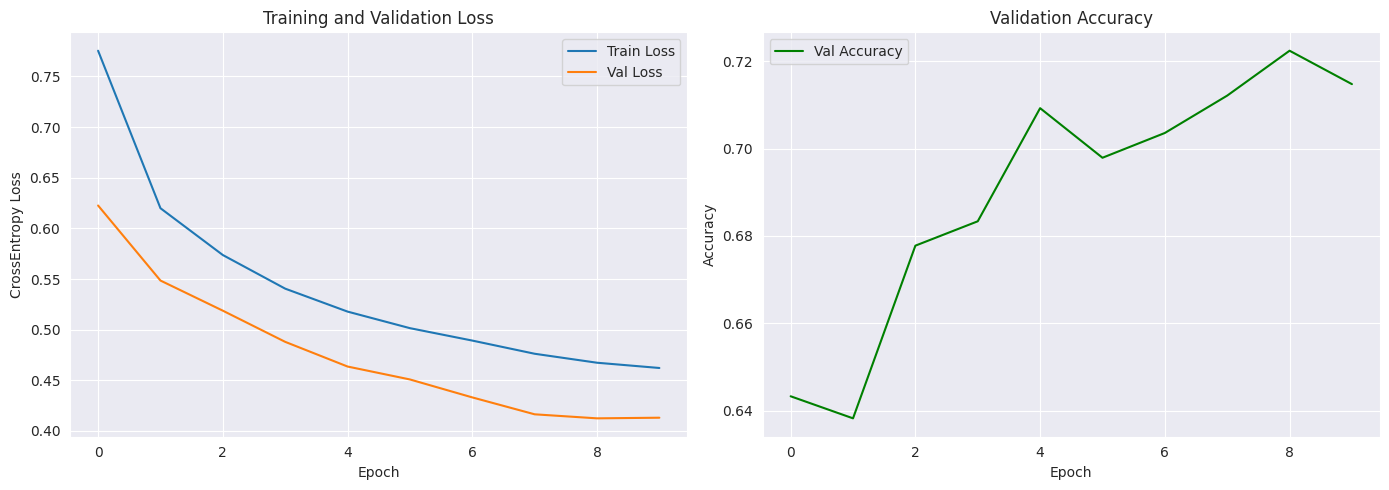

In [40]:
# 8) Plot the training history (Loss vs. Epoch)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.7244    0.7624    0.7429     42557
           1     0.8686    0.6337    0.7328     56500
           2     0.7525    0.8096    0.7800      7121
           3     0.4554    0.9411    0.6138       526
           4     0.2502    0.9398    0.3952      1995
           5     0.5010    0.7759    0.6089      3489
           6     0.4636    0.9868    0.6308      4015

    accuracy                         0.7147    116203
   macro avg     0.5737    0.8356    0.6435    116203
weighted avg     0.7711    0.7147    0.7258    116203



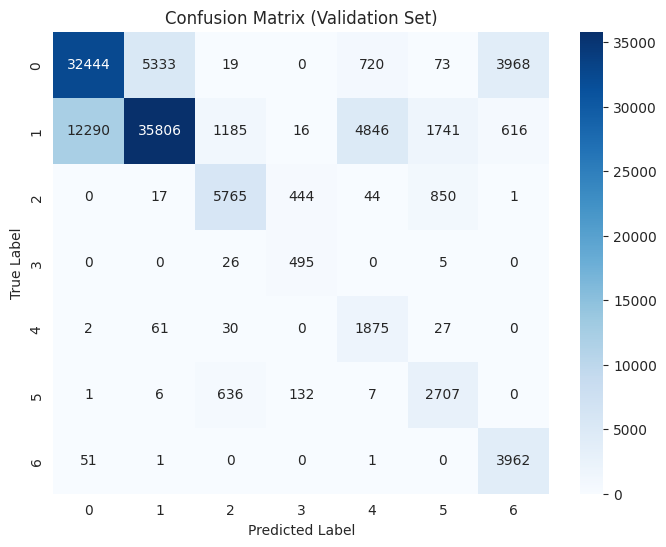

In [41]:
# 9) Final performance metrics (on validation set)
#    We'll compute the classification report and confusion matrix to
#    analyze how the model is performing across the 7 classes.

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

# Classification report
print("Classification Report (Validation Set):")
print(classification_report(all_targets, all_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(7), yticklabels=range(7))
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Tips:
- 'fetch_covtype' is a relatively large dataset. If running on CPU,
   you may need to reduce the the number of epochs
   to avoid long training times.
- In real-life scenarios, you may have to do much more in-depth
   preprocessing and data cleaning (e.g., handle missing values,
   encode categorical data, etc.).
- CrossEntropyLoss is suitable for multi-class classification
   with labels in [0..num_classes-1]. If the datasets is imbalanced, use class weights and consider using focal loss. The overall accuracy will be worse, but it will work much better for the minoritarian class.
- You can store the final model state_dict and your preprocessing
  scaler for applying to new data in production.
